In [120]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [121]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [122]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc


In [123]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [124]:
#use inspector tool
inspector = inspect(engine)

In [125]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [126]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [127]:
# Save references to each table
Station = Base.classes.station

Measurement = Base.classes.measurement 

In [128]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [129]:
columns = inspector.get_columns('Measurement')
for column in columns: 
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [130]:
engine.execute('SELECT * FROM Measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [131]:
# Find the most recent date in the data set.
strDate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
strDate

'2017-08-23'

In [132]:
preYear = dt.datetime.strptime(strDate, '%Y-%m-%d') - dt.timedelta(365)
preYear

datetime.datetime(2016, 8, 23, 0, 0)

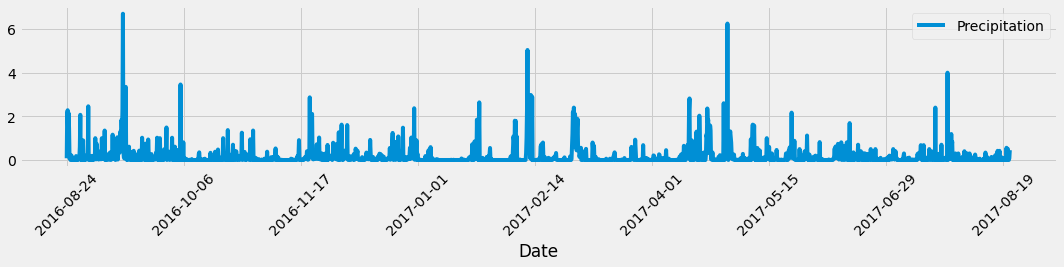

In [133]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

#session.query(Measurement.prcp, Measurement.date).\
    #filter(Measurement.date > '2016-08-23').\
    #order_by(Measurement.date).all()

    # Calculate the date one year from the last date in data set.
#query_date = dt.date(2017, 8, 23) - dt.timedelta(weeks=52.143)
#print('Query Date: ', query_date)


# Perform a query to retrieve the date and precipitation scores
annual_rf = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > preYear).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(annual_rf, columns=['Date', 'Precipitation']).dropna()
df.set_index('Date', inplace=True)
df.sort_index()

# # Sort the dataframe by date
df.plot(figsize=(15,4), rot=45)
plt.tight_layout()
plt.show()

# Use Pandas Plotting with Matplotlib to plot the data




In [134]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()
# pd.DataFrame({
#     'mean': df.mean(),
#     'median':df.median(),
#     'variance': df.var(),
#     'standard deviation': df.std(),
#     'SEM': df.sem()
# })

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [135]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).count()
total_stations

9

In [136]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
most_active = session.query(func.count(Measurement.station), Measurement.station).group_by(Measurement.station).having(func.count(Measurement.station) > 1).all()
desc = sorted(most_active, reverse=True)
desc

[(2772, 'USC00519281'),
 (2724, 'USC00519397'),
 (2709, 'USC00513117'),
 (2669, 'USC00519523'),
 (2612, 'USC00516128'),
 (2202, 'USC00514830'),
 (1979, 'USC00511918'),
 (1372, 'USC00517948'),
 (511, 'USC00518838')]

In [137]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
lowest = session.query(func.min(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
highest = session.query(func.max(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
average = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
print(lowest, highest, average)

[(54.0,)] [(85.0,)] [(71.66378066378067,)]


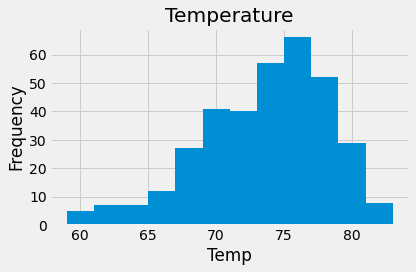

In [138]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temps = session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date > preYear).all()
temps_df = pd.DataFrame(temps, columns=['Temperature'])
temps_df.hist(bins=12)
label = 'tobs'
plt.ylabel('Frequency')
plt.xlabel('Temp')
plt.tight_layout()

# Close session

In [139]:
# Close Session
session.close()